# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

In [1]:
# 1. Load the Brown corpus
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\ilya-\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [2]:
from nltk.corpus import brown

brown_sentences = brown.sents()
brown_sentences[0]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of',
 "Atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 '``',
 'no',
 'evidence',
 "''",
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '.']

In [3]:
# 2. Plot cumulative coverage

from collections import Counter
from tqdm import tqdm

corpus_counter = Counter()

for sentence in tqdm(brown_sentences):
    corpus_counter.update(sentence)

100%|██████████| 57340/57340 [00:04<00:00, 13815.40it/s]


In [4]:
sorted_occurences = corpus_counter.most_common()

total_sum = 0
cumulative_count = []

for word, freq in sorted_occurences:
    cumulative_count.append(total_sum + freq)
    total_sum += freq

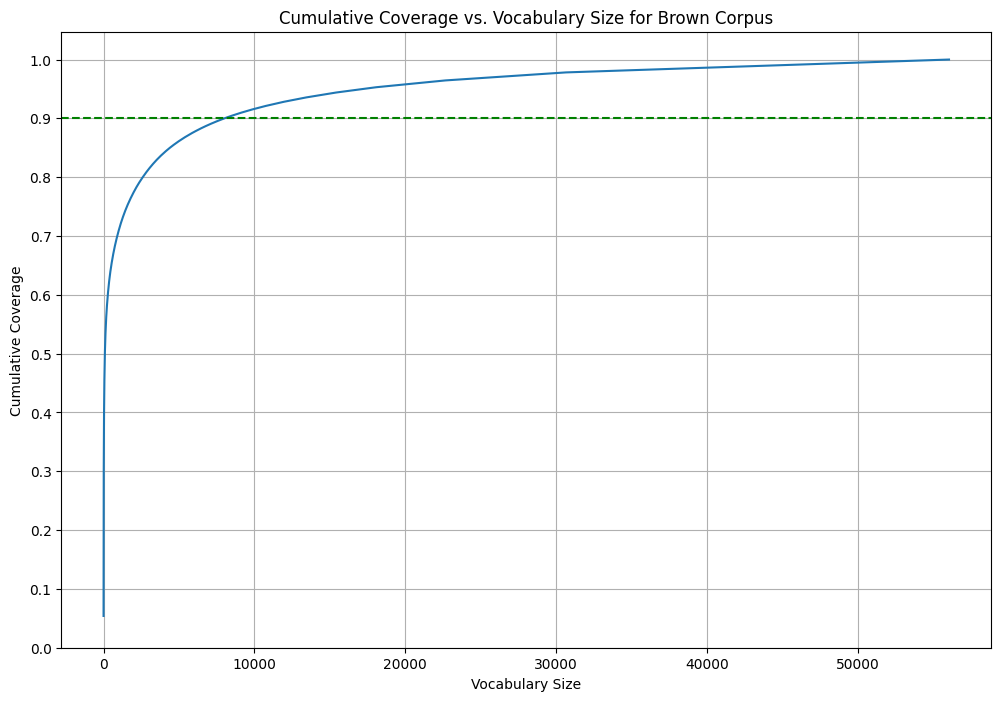

In [5]:
import matplotlib.pyplot as plt
import numpy as np

cumulative_coverage = np.array(cumulative_count, dtype=np.float32) / total_sum

plt.figure(figsize=(12, 8))
plt.title("Cumulative Coverage vs. Vocabulary Size for Brown Corpus")

plt.plot(np.arange(len(cumulative_count)), cumulative_coverage)
plt.axhline(y=0.9, linestyle='--', color='green')

plt.xlabel('Vocabulary Size')
plt.ylabel('Cumulative Coverage')

plt.yticks(np.arange(0, 1.1, 0.1))

plt.grid()
plt.show()

In [6]:
# 3. Select appropriate vocabulary size

k = int(np.min(np.where(cumulative_coverage >= 0.9)))
print(f"Optimal size: {k}")

print(cumulative_coverage[k], cumulative_coverage[k-1])

Optimal size: 8011
0.90000534 0.89999586


**Answers**:
1. Since in natural language words tend to have different frequencies (particles are used more often, domain specific words are rarely used across the whole corpora), the ordered list of words by frequences would be decreasing, with more and more gap between frequencies. Therefore, the cumulative coverage slows down the increase as the vocabulary size grows.

2. The Zipf's Law is the empirical law that explains the slow down: the frequency of the $r$-top word is proportional to $\frac{1}{r}$.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [ ]:
# your code here

# I adapt the code from the paper by R. Sennrich (https://arxiv.org/pdf/1508.07909)
from typing import List, Dict, Tuple
from collections import Counter, defaultdict
from nltk.tokenize.treebank import TreebankWordTokenizer
import re


class BPETokenizer:

    def __init__(self, vocab_size: int = 1000):
        self.vocab = None # {token1: 0, ...}
        self.inverse_vocab = None # index -> token
        self.merge_pairs = []   # [(token1, token2), ...]
        self.vocab_size = vocab_size # maximum possible size of the vocabulary
        self.pre_tokenizer = TreebankWordTokenizer() # pre-tokenizer for word split across sentences

    def get_stats(self, vocab: Dict[str, int]) -> Dict[Tuple[str, str], int]:
        """
        Compute statistics of consecutive pairs from current state of tokenized words.

        Parameters:
            vocab (Dict[str, int]): current tokenized words with count of word occurences (word -> frequency)

        Returns:
            Dict[Tuple[str, str], int]: possible merge pairs with frequency counts ((token1, token2) -> frequency)
        """
        pairs = defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split() # e.g. "C a t </w>" -> ['C', 'a', 't', '</w>']
            for i in range(len(symbols)-1):
                pairs[symbols[i],symbols[i+1]] += freq
        return pairs

    def merge_stats(self, pair: Tuple[str, str], v_in: Dict[str, int]) -> Dict[str, int]:
        """
        Update current state of tokenized words with a provided merge applied to all words.

        Parameters:
            pair (Tuple[str, str]): a merge pair ((token1, token2))
            v_in (Dict[str, int]): current tokenized words with count of word occurences (word -> frequency)

        Returns:
            Dict[str, int]: updated tokenized words with count of word occurences (word -> frequency)
        """
        v_out = {}
        bigram = re.escape(' '.join(pair))
        # match only '<bigram>' without any characters including spaces at the boundaries
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        for word in v_in:
            # bigram='ab': 'a b c a b </w>' -> 'ab c ab </w>'
            w_out = p.sub(''.join(pair), word)
            v_out[w_out] = v_in[word]
        return v_out

    def build_stats(self, corpus: List[List[str]]) -> Dict[str, int]:
        """
        Compute statistics of words from text corpus.

        First, count occurences for each word, then split words into letter tokens
        and add cross-word boundary token '</w>'.

        For instance, corpus -> {..., 'cat': 10, ...} -> {..., 'c a t </w>': 10, ...}

        Parameters:
            corpus (List[List[str]]): list of sentences that are list of words (strings)

        Returns:
            Dict[str, int]: tokenized words with count of word occurences (word -> frequency)
        """
        stats = defaultdict(int)

        corpus_counter = Counter()

        for sentence in corpus:
            corpus_counter.update(sentence)

        for word, freq in corpus_counter.items():
            key = ' '.join(list(word)) + " </w>"
            stats[key] = freq

        return stats

    def build_vocab(self, stats: Dict[str, int]) -> Dict[str, int]:
        """
        Build initial vocabulary (mapping from tokens to indices) from letters of words in the corpus.

        Parameters:
            stats: tokenized words with count of word occurences (word -> frequency)

        Returns:
            Dict[str, int]: initial vocabulary including special tokens.
        """
        vocab = {'<unk>': 0, '</w>': 1}

        alphabet = []
        for word in stats.keys():
            # Skip </w> part that stands at -1
            # 'c a t </w>' -> ['c', 'a', 't', '</w>'] -> 'c a t' -> add 'c', 'a', and 't'
            chars = ''.join(word.split()[:-1])
            for char in chars:
                if char not in alphabet:
                    alphabet.append(char)

        alphabet.sort()

        for char in alphabet:
            vocab[char] = len(vocab)

        return vocab

    def train(self, corpus: List[List[str]]):
        """
        Train BPE tokenizer by adding merge pairs and extending vocabulary.

        Stages:
        1. Compute word frequencies in corpus.
        2. Build initial vocabulary from corpus symbols.
        3. While size of vocabulary < maximum vocabulary size:
            3.1. Compute pair frequencies in corpus.
            3.2. Check if any pair was found; if not, break.
            3.3. Find the pair with maximum frequency.
            3.4. Apply merge for the statistics.
            3.5. Add merged pair as a new token to vocabulary.
        4. Build inverse vocabulary (index -> token).

        Parameters:
            corpus (List[List[str]]): pre-tokenized list of sentences (list of words)

        Returns:
            BPETokenizer (self): trained tokenizer
        """

        stats = self.build_stats(corpus)

        self.vocab = self.build_vocab(stats)

        pbar = tqdm(range(self.vocab_size))
        pbar.update(len(self.vocab))

        while len(self.vocab) < self.vocab_size:
            pairs = self.get_stats(stats)

            if len(pairs) == 0:
                self.inverse_vocab = {id: token for token, id in self.vocab.items()}
                pbar.close()
                return

            best = max(pairs, key=pairs.get)

            self.merge_pairs.append(best)

            stats = self.merge_stats(best, stats)

            self.vocab[''.join(best)] = len(self.vocab)
            pbar.update(1)

        pbar.close()

        self.inverse_vocab = {id: token for token, id in self.vocab.items()}

        return self

    def tokenize(self, sentence: str) -> List[int]:
        """
        Apply trained merges to a sentence to get a list of token indices from vocabulary.

        Note that instead of exhaustive search of possible merges from trained list of pairs,
        the algorithm looks at possible merges within each word and applies the merge preceeding
        others in the list of pairs. Thus, the complexity drops from O(|V|) to O(klogk) ~ O(1), where
        |V| is the vocabulary size and k is the length of a word (typically, 1 < k < 10).

        Stages:
        1. Rank each pair based on its position in the list of learned pairs.
        2. Pre-tokenize the given sentence (split into words).
        3. For each word in the pre-tokenized sentence:
            3.1. Split the word into individual characters and add cross-word boundary </w>
            3.2. Repeat:
                3.2.1. Find the pair with lowest rank that is presented in the trained list of pairs.
                3.2.2. Apply the merge for this word.
                3.2.3. Until no merges are possible.
            3.3. Append to the list of output ids converted tokens (unknown tokens are represented with <unk> token).
        4. Return the list of ids.

        Parameters:
            sentence (str): sentences as a string.

        Returns:
            List[int]: list of indices from vocabulary representing tokenenized sentence.

        """

        # Enforce training was performed
        assert self.vocab is not None

        merge_rank = {pair: i for i, pair in enumerate(self.merge_pairs)}
        pretokenized_sentence = self.pre_tokenizer.tokenize(sentence)
        input_ids = []

        for word in pretokenized_sentence:
            symbols = list(word) + ['</w>']

            while True:
                best_i = None
                best_rank = None

                # find best mergeable adjacent pair
                for i in range(len(symbols) - 1):
                    pair = (symbols[i], symbols[i + 1])
                    if pair in merge_rank:
                        rank = merge_rank[pair]
                        if best_rank is None or rank < best_rank:
                            best_rank = rank
                            best_i = i

                if best_i is None:
                    break  # no merges possible

                # apply best merge
                merged = symbols[best_i] + symbols[best_i + 1]
                symbols = (
                    symbols[:best_i]
                    + [merged]
                    + symbols[best_i + 2:]
                )

            for s in symbols:
                input_ids.append(self.vocab.get(s, self.vocab['<unk>']))

        return input_ids


    def convert_ids_to_tokens(self, input_ids: List[int]) -> List[str]:
        """
        Transform list of indicies to a list of tokens

        Parameters:
            input_ids (List[int]): indices (e.g. [0, 1])

        Returns:
            List[str]: tokens (e.g. ['<unk>', '</w>'])
        """
        return [self.inverse_vocab[id] for id in input_ids]

    def decode(self, input_ids: List[int]) -> str:
        """
        Decode the tokenized sentence back with proper cross-word boundaries.

        Parameters:
            input_ids (List[int]): indices.

        Returns:
            str: decoded sentece.
        """
        tokens = self.convert_ids_to_tokens(input_ids)

        i = 0
        result = []

        while i < len(tokens):
            if tokens[i] == '</w>':
                # Separate boundary token
                result.append(' ')
                i += 1
            elif tokens[i].endswith('</w>'):
                # Merged boundary token
                result.append(tokens[i][:-4])  # Remove </w>
                result.append(' ')
                i += 1
            else:
                # Regular token
                result.append(tokens[i])
                i += 1

        # Join and clean up spaces
        text = ''.join(result)
        # Fix multiple spaces if needed
        return ' '.join(text.split())  # Normalize whitespace

Example of work:

In [8]:
tokenizer = BPETokenizer(22)
example_corpus = [['low'] * 5, ['lower'] * 2, ['newest'] * 6, ['widest'] * 3]

tokenizer.train(example_corpus)

100%|██████████| 22/22 [00:00<00:00, 4782.06it/s]


In [9]:
tokenizer.vocab

{'<unk>': 0,
 '</w>': 1,
 'd': 2,
 'e': 3,
 'i': 4,
 'l': 5,
 'n': 6,
 'o': 7,
 'r': 8,
 's': 9,
 't': 10,
 'w': 11,
 'es': 12,
 'est': 13,
 'est</w>': 14,
 'lo': 15,
 'low': 16,
 'ne': 17,
 'new': 18,
 'newest</w>': 19,
 'low</w>': 20,
 'wi': 21}

In [10]:
input_ids = tokenizer.tokenize('lower i newest !')
input_ids

[16, 3, 8, 1, 4, 1, 19, 0, 1]

In [11]:
tokenizer.decode(input_ids)

'lower i newest <unk>'

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [ ]:
# your code here

In [12]:
# 1. Training BPETokenizer

bpe_tokenizer = BPETokenizer(8011)
bpe_tokenizer.train(brown_sentences)

100%|██████████| 8011/8011 [22:59<00:00,  5.81it/s] 


In [13]:
# 2. Computing Fertility scores and statistics

def fertility_by_words(sentence: List[str], tokenizer: BPETokenizer):
    total_words = len(sentence)
    assert total_words > 0

    encoded_output = tokenizer.tokenize(' '.join(sentence))

    total_tokens = len(encoded_output)

    return total_tokens / total_words

In [14]:
import random

random.seed(1)

brown_sample = random.choices(brown_sentences, k=1000)

fertility_scores = []
lengths = []

for sentence in tqdm(brown_sample):
    fertility_score = fertility_by_words(sentence, bpe_tokenizer)
    fertility_scores.append(fertility_score)

    length = len(bpe_tokenizer.tokenize(' '.join(sentence)))
    lengths.append(length)

100%|██████████| 1000/1000 [00:04<00:00, 228.40it/s]


In [15]:
import numpy as np
import pandas as pd

stats = pd.DataFrame({
    'fertility': {
        'mean': np.mean(fertility_scores),
        'std': np.std(fertility_scores)
    },
    'length': {
        'mean': np.mean(lengths),
        'std': np.std(lengths)
    }
})

In [16]:
print(stats)

      fertility     length
mean   1.263109  25.892000
std    0.244911  17.144163


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.